#  Silent_Horizon
---

> A regime-aware ensemble model for short-term crypto price movement prediction using XGBoost.

### Description :


>  * We define **market regimes** using handcrafted signal strength metrics, known as `Signal_Simulators`.
>  * The dataset is then **partitioned** based on how well each data point aligns with these regimes.
>  * We train **9 regime-specialist XGBoost classifiers**, each focused on predicting future price direction under different market conditions.
>  * A final **Meta\_Model** is trained to combine predictions from these specialists, using both their outputs and signal strengths as inputs.
>  * For comparison, we also train a **Benchmark XGBoost model** using the entire dataset and full feature set, without any regime separation.

---

## Necessary Code

Get the necessary libraries

In [1]:
!pip install ta optuna

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import plotly.io as pio
pio.renderers.default = "colab"

Data Source : https://www.kaggle.com/datasets/mczielinski/bitcoin-historical-data

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mczielinski/bitcoin-historical-data")

print("Path to dataset file:", path)

Path to dataset file: /kaggle/input/bitcoin-historical-data


In [4]:
df = pd.read_csv(f"{path}/btcusd_1-min_data.csv")
df["Timestamp"] = pd.to_datetime(df["Timestamp"], unit="s", utc=True)

df = df.sort_values("Timestamp").tail(45000) # Past 1 month

Smoothen the price

In [5]:
df['price'] = (df['Close'] + df['Open'])/2

## Features

In [6]:
from ta import momentum, trend, volatility, volume
from scipy.stats import skew, zscore

features = pd.DataFrame(index=df.index)

# Basic returns and volatility
features['log_ret_1'] = np.log(df['Close'] / df['Close'].shift(1))
features['log_ret_5'] = np.log(df['Close'] / df['Close'].shift(5))
features['log_ret_15'] = np.log(df['Close'] / df['Close'].shift(15))

features['pct_ret_1'] = df['Close'].pct_change(1)
features['pct_ret_5'] = df['Close'].pct_change(5)
features['pct_ret_15'] = df['Close'].pct_change(15)

features['cumsum_ret_10'] = features['pct_ret_1'].rolling(10).sum()
features['ret_std_20'] = features['pct_ret_1'].rolling(20).std()

features['vol_20'] = features['log_ret_1'].rolling(20).std()

In [7]:
# Momentum Indicators
macd = trend.MACD(df['Close'])
features['MACD'] = macd.macd()
features['MACD_diff'] = macd.macd_diff()

stoch = momentum.StochasticOscillator(df['High'], df['Low'], df['Close'])
features['Stoch_%K'] = stoch.stoch()
features['Stoch_%D'] = stoch.stoch_signal()

features['TSI'] = momentum.TSIIndicator(df['Close']).tsi()
features['ROC_10'] = momentum.ROCIndicator(df['Close'], window=10).roc()
features['Williams_%R'] = momentum.WilliamsRIndicator(df['High'], df['Low'], df['Close']).williams_r()

In [8]:
# Volatility and Range
features['ATR_14'] = volatility.AverageTrueRange(df['High'], df['Low'], df['Close']).average_true_range()
bb = volatility.BollingerBands(df['Close'])
features['BB_width'] = bb.bollinger_hband() - bb.bollinger_lband()
features['High_Low_range'] = df['High'] - df['Low']
features['Close_std_20'] = df['Close'].rolling(20).std()
features['Donchian_width_20'] = df['High'].rolling(20).max() - df['Low'].rolling(20).min()

In [9]:
# Moving Averages, Trend Features
features['MA_5'] = df['Close'].rolling(5).mean()
features['MA_10'] = df['Close'].rolling(10).mean()
features['MA_20'] = df['Close'].rolling(20).mean()
features['MA_50'] = df['Close'].rolling(50).mean()

features['EMA_10'] = df['Close'].ewm(span=10).mean()
features['EMA_20'] = df['Close'].ewm(span=20).mean()
features['EMA_50'] = df['Close'].ewm(span=50).mean()

features['Price_over_MA_20'] = df['Close'] / features['MA_20']
features['MA_slope_10'] = features['MA_10'] - features['MA_10'].shift(1)

adx = trend.ADXIndicator(df['High'], df['Low'], df['Close'])
features['ADX'] = adx.adx()
features['+DI'] = adx.adx_pos()
features['-DI'] = adx.adx_neg()

In [10]:
# Volume Features
features['rolling_vol_20'] = df['Volume'].rolling(20).mean()
features['vol_z'] = (df['Volume'] - df['Volume'].rolling(20).mean()) / (df['Volume'].rolling(20).std() + 1e-6)

features['OBV'] = volume.OnBalanceVolumeIndicator(df['Close'], df['Volume']).on_balance_volume()
features['OBV_diff'] = features['OBV'].diff()

features['AD_line'] = volume.AccDistIndexIndicator(df['High'], df['Low'], df['Close'], df['Volume']).acc_dist_index()

In [11]:
# Bollinger Bands
features['bb_mid'] = bb.bollinger_mavg()
features['bb_std'] = df['Close'].rolling(20).std()
features['bb_upper'] = features['bb_mid'] + 2 * features['bb_std']
features['bb_lower'] = features['bb_mid'] - 2 * features['bb_std']
features['bb_width'] = (features['bb_upper'] - features['bb_lower']) / features['bb_mid']

# RSI
delta = df['Close'].diff()
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
avg_gain = gain.rolling(50).mean()
avg_loss = loss.rolling(50).mean()
rs = avg_gain / (avg_loss + 1e-6)
features['rsi_14'] = 100 - (100 / (1 + rs))

In [12]:
# Price Structure
features['Close_over_BB_mid'] = df['Close'] / features['bb_mid']
features['Close_over_BB_upper'] = df['Close'] / bb.bollinger_hband()

vwap = (df['Volume'] * (df['High'] + df['Low'] + df['Close']) / 3).cumsum() / df['Volume'].cumsum()
features['Close_over_VWAP'] = df['Close'] / vwap

features['Support_bounce'] = (df['Low'] <= df['Low'].rolling(10).min()).astype(int)
features['Range_compression_score'] = (features['BB_width'] - features['BB_width'].rolling(50).min()) / \
                                       (features['BB_width'].rolling(50).max() - features['BB_width'].rolling(50).min())


Signal_Indicators

In [13]:
# 1. MA distance signal (Z-scored distance from MA20)
df['sig_strength_ma'] = (df['Close'] - features['MA_20']) / features['Close_std_20']

# 2. RSI deviation from neutral (centered, normalized)
df['sig_strength_rsi'] = (features['rsi_14'] - 50) / 50

# 3. MACD strength (MACD minus Signal Line)
df['sig_strength_macd'] = features['MACD_diff']

# 4. BB breakout strength (distance outside bands, clipped)
df['sig_strength_bb_breakout'] = ((df['Close'] - bb.bollinger_mavg()) / features['BB_width']).clip(-3, 3)

# 5. OBV momentum (z-scored OBV over 50 bars)
df['sig_strength_obv'] = (features['OBV'] - features['OBV'].rolling(50).mean()) / (features['OBV'].rolling(50).std() + 1e-6)

# 6. VWAP reversion signal (percent deviation from VWAP)
df['sig_strength_vwap_reversion'] = (df['Close'] - vwap) / (vwap + 1e-6)

# 7. Stochastic Oscillator centered signal (%K - %D)
df['sig_strength_stoch'] = (features['Stoch_%K'] - features['Stoch_%D']) / 100

# 8. ROC momentum signal
df['sig_strength_roc'] = features['ROC_10'] / 100

# 9. ADX strength signal (+DI - -DI), scaled by ADX itself
df['sig_strength_adx'] = ((features['+DI'] - features['-DI']) / 100) * (features['ADX'] / 50)

In [14]:
signals = ['sig_strength_ma' ,
           'sig_strength_rsi',
           'sig_strength_macd',
           'sig_strength_bb_breakout',
           'sig_strength_obv',
           'sig_strength_vwap_reversion',
           'sig_strength_stoch',
           'sig_strength_roc',
           'sig_strength_adx']

strong_indices = []
specificity = 0.30

for signal in signals :
  thresh1,thresh2 = df[signal].quantile(specificity),df[signal].quantile(1-specificity)
  df1 = df[df[signal] < thresh1]
  df2 = df[df[signal] > thresh2]
  df3 = pd.concat([df1,df2])
  for t in df3['Timestamp'].values:
    strong_indices.append(t)
  df3['Fut_ret'] = (df3['price'].shift(-5).rolling(5).mean()/df3['price'].shift(1).rolling(5).mean())
  print(df3['Fut_ret'].quantile(0.25) , df3['Fut_ret'].quantile(0.75))

0.9994648823445061 1.000543545847762
0.9995723106475124 1.0004359185752434
0.9993043733035071 1.0007129042518446
0.9994648823445061 1.000543545847762
0.9995027602823062 1.0004918655458204
0.9996067705996661 1.0003843083308241
0.9992946783054891 1.0006989540357005
0.9993432498480506 1.0006718136098514
0.9995781257206287 1.0004275534852451


In [15]:
len(np.unique(strong_indices))/len(df)

0.9956888888888888

almost all of the market is covered by some of the other signal

In [16]:
import seaborn as sns

def plot_signal_vs_price(df, signal_col):
    # Remove NaNs
    df = df[[signal_col, 'price']].dropna().copy()
    df['signal_strength'] = df[signal_col]
    col = 'price'
    # Plot
    plt.figure(figsize=(12, 5))
    sns.scatterplot(data=df, x=col, y=signal_col, hue='signal_strength', palette='coolwarm', alpha=0.6)
    plt.title(f"{signal_col} vs {col} with Signal Hue")
    plt.xlabel(col)
    plt.ylabel(signal_col)
    plt.xlim(df[col].min(), df[col].max())
    plt.ylim(df[signal_col].min(), df[signal_col].max())
    plt.axvline(0, color='gray', linestyle='--')
    plt.show()

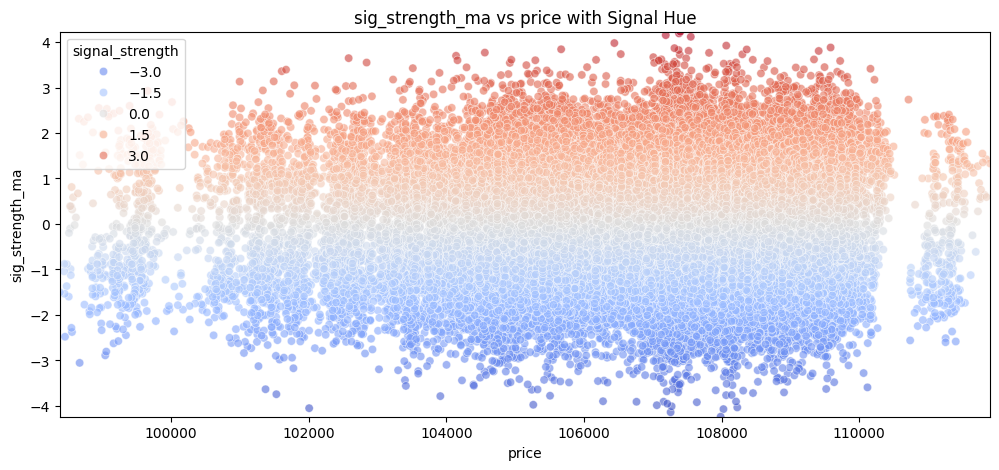

In [17]:
plot_signal_vs_price(df,signals[0])

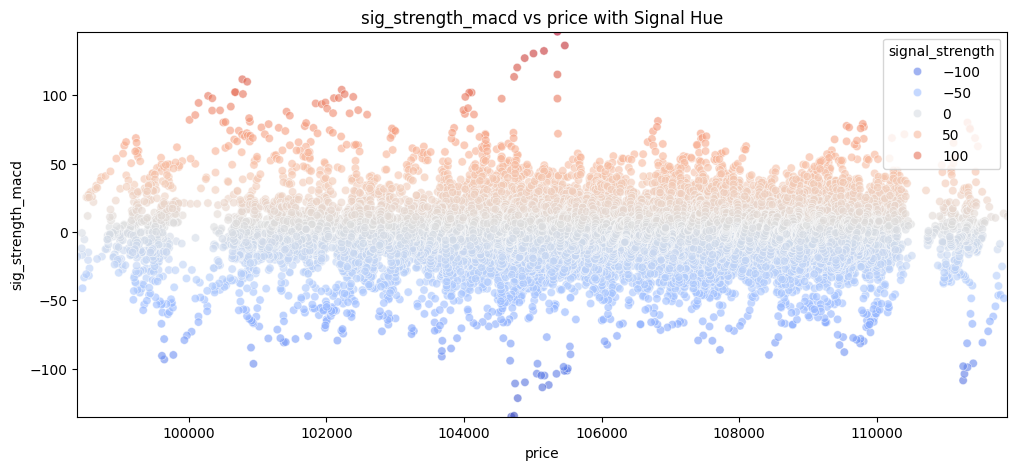

In [18]:
plot_signal_vs_price(df,signals[2])

In [19]:
def plot_with_signal_overlay(df, signal_col='sig_strength_macd', price_col='price', window=600):
    df = df[[price_col, signal_col]].dropna().copy()

    plt.figure(figsize=(12, 5))
    sc = plt.scatter(df.index[-window:], df[price_col].tail(window),
                     c=df[signal_col].tail(window), cmap='coolwarm', s=10)
    plt.colorbar(sc, label=signal_col)
    plt.title(f"{price_col} with {signal_col} overlay")
    plt.xlabel("Time")
    plt.ylabel("Price")
    plt.grid(True)
    plt.show()

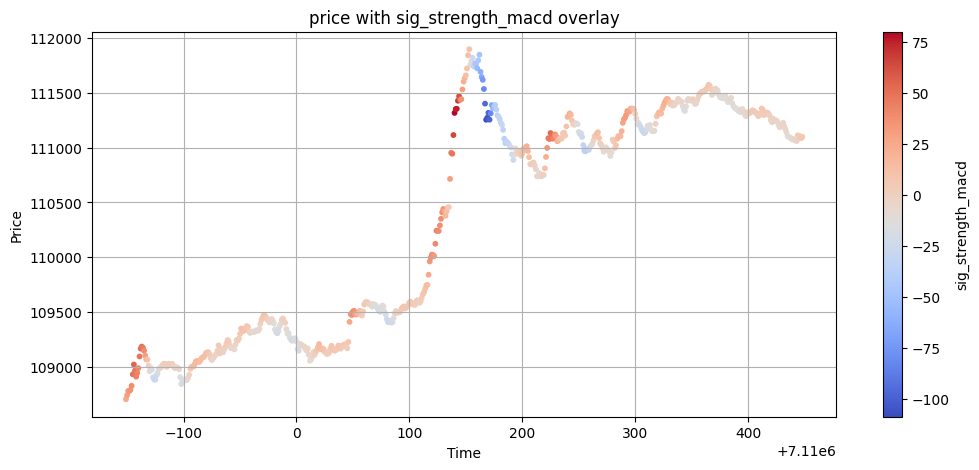

In [20]:
plot_with_signal_overlay(df, signal_col=signals[2])

In [21]:
# XGBoost bagging trainer per signal

from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

horizon=9
quantile=0.225
label_col = 'Target'
models = []

def analyse_and_train(signal_name):
    # 1. Partition strong parts of dataset based on signal
    low, high = df[signal_name].quantile(quantile), df[signal_name].quantile(1 - quantile)
    strong_mask = (df[signal_name] < low) | (df[signal_name] > high)

    # Get matching features and df slice using the same index
    X_strong = features.loc[strong_mask].copy()
    df_strong = df.loc[strong_mask].copy()

    # 2. Compute non-leaky forward return
    future_mean = df_strong['price'].shift(-horizon).rolling(horizon).mean()
    past_mean = df_strong['price'].rolling(horizon).mean().shift(1)
    df_strong['fut_ret'] = np.log(future_mean / past_mean)
    df_strong['fut_ret'] = (df_strong['fut_ret'] - df_strong['fut_ret'].mean())/df_strong['fut_ret'].std()

    # 3. Labeling
    threshold1 = df_strong['fut_ret'].quantile(0.25)
    threshold2 = df_strong['fut_ret'].quantile(0.75)
    df_strong[label_col] = np.where(df_strong['fut_ret'] < threshold1, -1,
                            np.where(df_strong['fut_ret'] > threshold2, 1, 0))

    # 4. Drop rows with NaNs (from rolling)
    valid_idx = df_strong.dropna(subset=['fut_ret', label_col]).index
    X = X_strong.loc[valid_idx]
    y = df_strong.loc[valid_idx, label_col]
    y = np.array(y)
    y = 1+y # 0 for SELL , 1 for HOLD , 2 for BUY

    # 6. Train/Test Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
    SUM1 = len(y_train)
    SUM = len(y_test)

    # 7. Train XGB Classifier
    model = XGBClassifier(n_estimators=100, max_depth=4, learning_rate=0.05, use_label_encoder=True, verbosity = 0, eval_metric='mlogloss')
    model.fit(X_train, y_train)

    # 8. Predict & Evaluate
    y_pred = model.predict(X_train)
    acc = accuracy_score(y_train, y_pred)
    print(f"Train {signal_name} | Accuracy: {acc:.4f} | Positives: {sum(y_pred==2)/SUM1}, Negatives: {sum(y_pred==0)/SUM1}, Neutral: {sum(y_pred==1)/SUM1}")

    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"✅ {signal_name} | Accuracy: {acc:.4f} | Positives: {sum(y_pred==2)/SUM}, Negatives: {sum(y_pred==0)/SUM}, Neutral: {sum(y_pred==1)/SUM}")

    # 9. Store model
    models.append((signal_name, model))


In [22]:
for signal in signals:
  analyse_and_train(signal)

Train sig_strength_ma | Accuracy: 0.7007 | Positives: 0.2916125842141047, Negatives: 0.28864577538784847, Neutral: 0.41974164039804684
✅ sig_strength_ma | Accuracy: 0.7375 | Positives: 0.15377008652657603, Negatives: 0.1639060568603214, Neutral: 0.6823238566131026
Train sig_strength_rsi | Accuracy: 0.7162 | Positives: 0.2374443344878773, Negatives: 0.24826818406729342, Neutral: 0.5142874814448293
✅ sig_strength_rsi | Accuracy: 0.7622 | Positives: 0.12469074715487383, Negatives: 0.13038099950519544, Neutral: 0.7449282533399307
Train sig_strength_macd | Accuracy: 0.6775 | Positives: 0.1956844318041301, Negatives: 0.18603932236923457, Neutral: 0.6182762458266353
✅ sig_strength_macd | Accuracy: 0.6345 | Positives: 0.16913946587537093, Negatives: 0.16048466864490604, Neutral: 0.670375865479723
Train sig_strength_bb_breakout | Accuracy: 0.7007 | Positives: 0.2916125842141047, Negatives: 0.28864577538784847, Neutral: 0.41974164039804684
✅ sig_strength_bb_breakout | Accuracy: 0.7375 | Positive

### Checks for data leak

| Aspect                     | Observation                                                                                 | Verdict   |
| -------------------------- | ------------------------------------------------------------------------------------------- | --------- |
| **fut\_ret computation**   | You used `shift(-H).rolling(H).mean()` for future and `rolling(H).mean().shift(1)` for past | ✅ Correct |
| **Signal usage**           | You dropped `signal_name` from features used in model                                       | ✅ Correct |
| **Feature frame**          | You used `features.loc[mask]` separately from `df.loc[mask]`                                | ✅ Correct |
| **Train-test split**       | `shuffle=False` used (important for time series data)                                       | ✅ Correct |
| **Label balance**          | Class distribution varies across signals, not always 50/50                                  | ✅ Good    |
| **Test accuracy is lower** | Models perform slightly worse on test set → no data leakage                                 | ✅ Pass    |

✅ Conclusion: There is no sign of data leakage in your pipeline. You're doing things properly and rigorously.

In [23]:
len(models)

9

In [24]:
X = features.values

In [25]:
for i in range(0,9):
    y = models[i][1].predict(X)
    print(models[i][0], round(sum(y==0)/len(y),3) , round(sum(y==1)/len(y),3) , round(sum(y==2)/len(y),3))

sig_strength_ma 0.177 0.644 0.179
sig_strength_rsi 0.278 0.45 0.272
sig_strength_macd 0.095 0.808 0.097
sig_strength_bb_breakout 0.177 0.644 0.179
sig_strength_obv 0.171 0.646 0.183
sig_strength_vwap_reversion 0.165 0.665 0.17
sig_strength_stoch 0.232 0.522 0.246
sig_strength_roc 0.087 0.827 0.085
sig_strength_adx 0.26 0.51 0.23


In [26]:
def plot_model_signals_with_strength(model_tuple, features, df, signal_strength_col,
                                               window_minutes=240, offset_minutes=120, lookback=1000):
    signal_name, model = model_tuple

    # Predict
    X = features.iloc[lookback:].values
    y_pred = model.predict(X)

    # Align predictions with df
    df2 = pd.DataFrame({
        'pred': y_pred,
        'Price': df['price'].iloc[lookback:].reset_index(drop=True),
        'Timestamp': df['Timestamp'].iloc[lookback:].reset_index(drop=True),
        'Strength': df[signal_strength_col].iloc[lookback:].reset_index(drop=True)
    })

    df2['Direction'] = df2['pred'].map({2: 'BUY', 0: 'SELL', 1: 'HOLD'})

    # Subset recent window
    t_end = df2['Timestamp'].max() - pd.Timedelta(minutes=offset_minutes)
    t_start = t_end - pd.Timedelta(minutes=window_minutes)
    plot_df = df2[(df2['Timestamp'] >= t_start) & (df2['Timestamp'] <= t_end)].reset_index(drop=True)

    # Split predictions
    buy = plot_df[plot_df['pred'] == 2]
    sell = plot_df[plot_df['pred'] == 0]
    hold = plot_df[plot_df['pred'] == 1]

    # Calculate horizontal line for baseline hue strip
    price_floor = plot_df['Price'].min() - 100
    strength_y = [price_floor] * len(plot_df)

    # Plot
    fig, ax = plt.subplots(figsize=(14, 5))

    # Background signal strength hue strip (horizontal)
    norm = plt.Normalize(plot_df['Strength'].min(), plot_df['Strength'].max())
    cmap = plt.get_cmap('coolwarm')
    colors = cmap(norm(plot_df['Strength']))
    ax.scatter(plot_df['Timestamp'], strength_y, color=colors, s=15, alpha=0.8, label='Signal Strength Strip')

    # Price line
    ax.plot(plot_df['Timestamp'], plot_df['Price'], color='black', linewidth=1.2, label='Close Price')

    # Model decisions
    ax.scatter(buy['Timestamp'], buy['Price'], color='green', marker='^', s=50, alpha=0.6, label='BUY (↑)')
    ax.scatter(sell['Timestamp'], sell['Price'], color='red', marker='v', s=50, alpha=0.6, label='SELL (↓)')
    ax.scatter(hold['Timestamp'], hold['Price'], color='grey', marker='o', s=35, alpha=0.4, label='HOLD (•)')

    # Labels and formatting
    ax.set_title(f"{signal_name.upper()} Model Decisions with Signal Strength (Baseline Strip)")
    ax.set_xlabel("Time")
    ax.set_ylabel("Price")
    ax.legend(loc='upper left')
    ax.grid(True)

    # Add colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, pad=0.01)
    cbar.set_label(f"{signal_strength_col}")

    plt.tight_layout()
    plt.show()

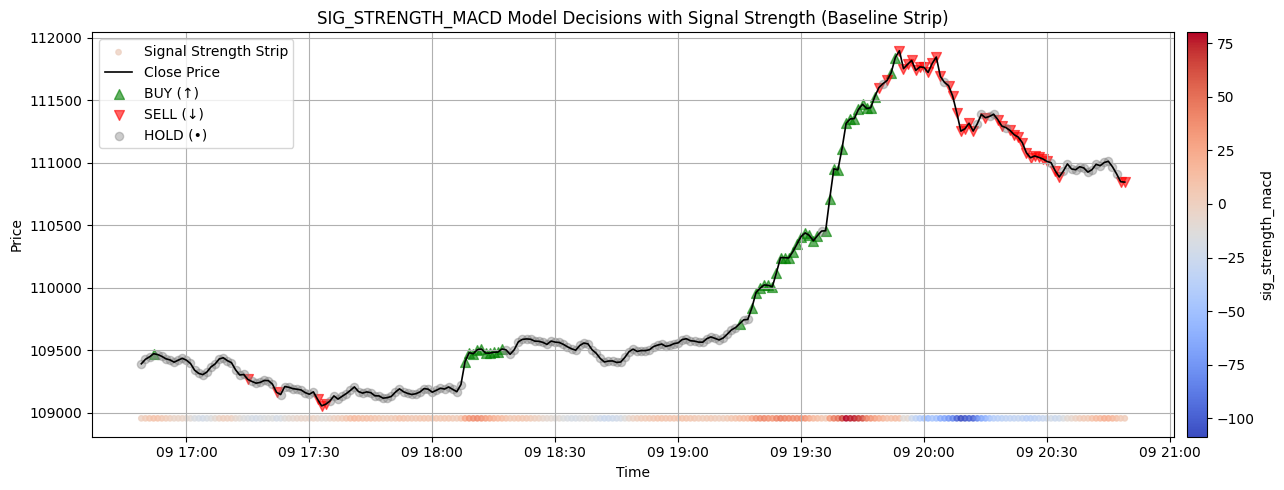

In [27]:
T = 240
plot_model_signals_with_strength(models[2], features, df,
                                 signal_strength_col='sig_strength_macd',
                                 window_minutes=240, offset_minutes=T)  # For MACD model

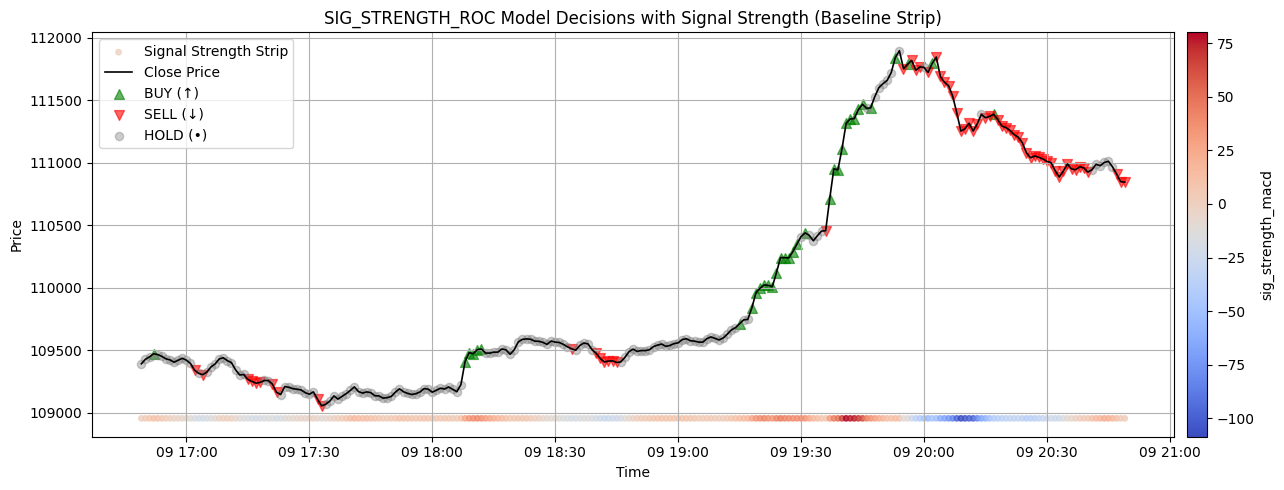

In [28]:
plot_model_signals_with_strength(models[7], features, df,
                                 signal_strength_col='sig_strength_macd',
                                 window_minutes=240, offset_minutes=T)

Here we have a false suggestion of sell at 18:40. But we know not to trust this suggestion as that period of time is not a regime which is the specialization of this specific model.

Let's Normalise the signals for training the Meta Model

In [29]:
df_signals = df[signals].copy()
for signal in signals:
  df_signals[signal] = (df_signals[signal] - df_signals[signal].mean())/df_signals[signal].std()

### Targets for meta model

In [30]:
horizon = 9
future_mean = df['price'].shift(-horizon).rolling(horizon).mean()
past_mean = df['price'].rolling(horizon).mean().shift(1)
future_returns = np.log(future_mean / past_mean)

thresh = np.log(1.0005)   # Trading Threshold
targets = np.where(future_returns > thresh, 1 ,
            np.where(future_returns < -thresh, -1 , 0))
np.mean(np.abs(targets))

np.float64(0.5116222222222222)

In [31]:
df_signals['Target'] = targets
df_signals.dropna(inplace=True)

## Features for the meta model

In [32]:
X_features = features.tail(30000).copy().reset_index(drop=True).values     # shape: (30000, 40)

In [33]:
model_preds = []

for signal_name, model in models:
    pred = model.predict(X_features)  # shape: (30000,)
    model_preds.append(pred.reshape(-1, 1))

model_preds = np.hstack(model_preds)  # shape: (30000, 9)

### Final Data Processing

In [34]:
X_meta_all = np.hstack([X_features, model_preds])  # shape: (30000, 40 + 9 = 49)

In [35]:
y_meta = df_signals.tail(30000)['Target'].values + 1  # shape: (30000,)

## Training

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X_meta_all, y_meta, test_size=0.2, shuffle=False)

meta_model = XGBClassifier(n_estimators=200, max_depth=5, learning_rate=0.03,
                           objective='multi:softmax', num_class=3, use_label_encoder=False, verbose = 0, eval_metric='mlogloss')

meta_model.fit(X_train, y_train)

y_pred_train = meta_model.predict(X_train)
y_pred_test = meta_model.predict(X_test)

print("📊 Train Accuracy:", accuracy_score(y_train, y_pred_train))
print("📊 Test Accuracy:", accuracy_score(y_test, y_pred_test))
print("\nTest Class Distribution:\n", pd.Series(y_pred_test).map({0:'SELL',1:'HOLD',2:'BUY'}).value_counts())

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning:

[19:07:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder", "verbose" } are not used.




📊 Train Accuracy: 0.7255833333333334
📊 Test Accuracy: 0.7186666666666667

Test Class Distribution:
 HOLD    4261
BUY      889
SELL     850
Name: count, dtype: int64


## Comparison with a basic XGBoost Model

In [37]:
X_signal2 = df_signals[signals].values
y = df_signals['Target'].values
y = y + 1

X_train, X_test, y_train, y_test = train_test_split(X_signal2, y, test_size=0.2, shuffle=False)

model_0 = XGBClassifier(n_estimators=200, max_depth=5, learning_rate=0.03,
                           objective='multi:softmax', num_class=3, use_label_encoder=False, verbose = 0, eval_metric='mlogloss')

model_0.fit(X_train, y_train)

models.append(('benchmark_model', model_0))

y_pred_train = model_0.predict(X_train)
y_pred_test = model_0.predict(X_test)

print("📊 Train Accuracy:", accuracy_score(y_train, y_pred_train))
print("📊 Test Accuracy:", accuracy_score(y_test, y_pred_test))
print("\nTest Class Distribution:\n", pd.Series(y_pred_test).map({0:'SELL',1:'HOLD',2:'BUY'}).value_counts())

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning:

[19:07:22] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder", "verbose" } are not used.




📊 Train Accuracy: 0.6669354838709678
📊 Test Accuracy: 0.7077077077077077

Test Class Distribution:
 HOLD    6372
SELL    1364
BUY     1255
Name: count, dtype: int64


## HP_Tuning

one final, best push we can make to our model

In [38]:
import optuna
%matplotlib inline

X_train, X_test, y_train, y_test = train_test_split(X_meta_all, y_meta, test_size=0.2, shuffle=False)

# ✅ Objective function
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 300),
        "max_depth": trial.suggest_int("max_depth", 3, 7),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 5),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "objective": "multi:softmax",
        "num_class": 3,
        "eval_metric": "mlogloss",
        "use_label_encoder": False,
        "verbosity": 0,
    }

    model = XGBClassifier(**params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    return acc

# ✅ Run Optuna Study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=400, show_progress_bar=True)

# ✅ Show best results
print("✅ Best Test Accuracy:", study.best_value)
print("🧠 Best Training Parameters:\n", study.best_params)

[I 2025-07-10 19:07:28,593] A new study created in memory with name: no-name-d0ecd722-fd09-4a67-afdb-9821446a57a3


  0%|          | 0/400 [00:00<?, ?it/s]

[I 2025-07-10 19:07:33,744] Trial 0 finished with value: 0.7183333333333334 and parameters: {'n_estimators': 198, 'max_depth': 6, 'learning_rate': 0.0678591999637549, 'subsample': 0.8622826220197206, 'colsample_bytree': 0.6170711503082768, 'gamma': 3.0828487902899546, 'min_child_weight': 9}. Best is trial 0 with value: 0.7183333333333334.
[I 2025-07-10 19:07:39,076] Trial 1 finished with value: 0.7165 and parameters: {'n_estimators': 102, 'max_depth': 4, 'learning_rate': 0.0011293784760482914, 'subsample': 0.9041033395758715, 'colsample_bytree': 0.7862427472108711, 'gamma': 2.892111148347671, 'min_child_weight': 6}. Best is trial 0 with value: 0.7183333333333334.
[I 2025-07-10 19:07:44,691] Trial 2 finished with value: 0.722 and parameters: {'n_estimators': 157, 'max_depth': 5, 'learning_rate': 0.047556477035163455, 'subsample': 0.8278873537832687, 'colsample_bytree': 0.6519087190280116, 'gamma': 1.9694684297545844, 'min_child_weight': 1}. Best is trial 2 with value: 0.722.
[I 2025-07-

In [39]:
import optuna.visualization as vis

# Optimization History
vis.plot_optimization_history(study)

Almost all the models give an accuracy ~ 72% 🎉

In [40]:
vis.plot_param_importances(study)

In [42]:
best_model = XGBClassifier(**study.best_params)
best_model.fit(X_train, y_train)

y_pred_train = best_model.predict(X_train)
y_pred_test = best_model.predict(X_test)

models.append(('best_meta_model', best_model))

print("📊 Train Accuracy:", accuracy_score(y_train, y_pred_train))
print("📊 Test Accuracy:", accuracy_score(y_test, y_pred_test))

📊 Train Accuracy: 0.7172083333333333
📊 Test Accuracy: 0.7295


## Save all the Models

In [43]:
import os
import joblib

# Create a directory if not exists
os.makedirs("saved_models/regime_models", exist_ok=True)

# Save each model with its signal name
for signal_name, model in models:
    path = f"saved_models/regime_models/{signal_name}_xgb.pkl"
    joblib.dump(model, path)
    print(f"✅ Saved model: {path}")

✅ Saved model: saved_models/regime_models/sig_strength_ma_xgb.pkl
✅ Saved model: saved_models/regime_models/sig_strength_rsi_xgb.pkl
✅ Saved model: saved_models/regime_models/sig_strength_macd_xgb.pkl
✅ Saved model: saved_models/regime_models/sig_strength_bb_breakout_xgb.pkl
✅ Saved model: saved_models/regime_models/sig_strength_obv_xgb.pkl
✅ Saved model: saved_models/regime_models/sig_strength_vwap_reversion_xgb.pkl
✅ Saved model: saved_models/regime_models/sig_strength_stoch_xgb.pkl
✅ Saved model: saved_models/regime_models/sig_strength_roc_xgb.pkl
✅ Saved model: saved_models/regime_models/sig_strength_adx_xgb.pkl
✅ Saved model: saved_models/regime_models/benchmark_model_xgb.pkl
✅ Saved model: saved_models/regime_models/best_meta_model_xgb.pkl


## Conclusion

In this project, we built a **regime-aware ensemble trading strategy** using:
>- A rich set of **technical indicators** and handcrafted market signals,
>- Multiple **XGBoost classifiers**, each specialized for a distinct signal regime,
>- A meta-ensemble model that combines **raw features** and **model predictions** for final decision making.

Our approach achieved **better performance than benchmark XGBoost model** trained directly on raw features, while offering:

* Greater **interpretability** through signal-specific decision patterns,
* Modular **scalability** for real-time application or further research,
* A strong foundation for **alpha generation** based on multi-factor reasoning.

🔒 Data leakage was strictly avoided, and validation methods were designed to reflect **realistic future prediction scenarios**.

This work serves as a compelling demonstration of combining **traditional feature engineering**, **machine learning ensemble design**, and **signal-based regime modeling** — essential skills for quantitative trading and research roles.

> ✨ With thoughtful modeling, strategic evaluation, and a clear view of the market’s structure, machine learning in trading becomes not just viable — but powerful.

-----